In [ ]:
pip install transformers

In [ ]:
pip install datasets

In [ ]:
import pandas as pd
import numpy as np
import json
import torch
import time
import matplotlib.pyplot as plt
from datasets import load_dataset, load_metric
import transformers
from transformers import AlbertForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer
import torch
import numpy as np

In [ ]:
dataset = load_dataset("glue", 'mnli')
train_set = dataset["train"]

Dataset glue downloaded and prepared to /root/.cache/huggingface/datasets/glue/mnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad. Subsequent calls will reuse this data.


In [ ]:
cd /content/drive/MyDrive/albert_mnli/

/content/drive/.shortcut-targets-by-id/1um3P4Kt2M1HPFkW85fAUIHAzCgmwtlmv/albert_mnli


In [ ]:
ls

aum_1_6.pt  filtered_index_1.txt  flip_index_1.json
aum_2_6.pt  filtered_index_2.txt  flip_index_2.json


In [ ]:
my_file = open("filtered_index_1.txt", "r")
content = my_file.read()
content = content.split(',')
content[0] = '2'
content[-1] = '392699'
filtered_1 = np.array(list(map(int, content)))

In [ ]:
my_file = open("filtered_index_2.txt", "r")
content = my_file.read()
content = content.split(',')
content[0] = '2'
content[-1] = '392699'
filtered_2 = np.array(list(map(int, content)))

In [ ]:
len(filtered_1), len(filtered_2)

(57078, 51543)

In [ ]:
union_list = set.union(set(filtered_1), set(filtered_2))

In [ ]:
union_list = list(union_list)

In [ ]:
len(union_list)

80018

# Finding different threshold

In [ ]:
with open('flip_index_1.json') as fp:
    flip_index_1 = json.load(fp)
with open('flip_index_2.json') as fp:
    flip_index_2 = json.load(fp)

In [ ]:
aum_1 = torch.load("aum_1_6.pt", map_location=torch.device('cpu')).detach().numpy()
aum_2 = torch.load("aum_2_6.pt", map_location=torch.device('cpu')).detach().numpy()

In [ ]:
t = np.quantile(aum_1[flip_index_1], 0.99)
t

0.15513633698225066

In [ ]:
nf1 = list(set(range(len(train_set))) - set(flip_index_1))
nf2 = list(set(range(len(train_set))) - set(flip_index_2))

In [ ]:
def filter_data(threshold = 0.99):
    t1 = np.quantile(aum_1[flip_index_1], threshold)
    t2 = np.quantile(aum_2[flip_index_2], threshold)

    filter_list = []

    for i in range(len(aum_1)):
        if aum_1[i] < t1:
            if i in flip_index_1:
                pass
            else:
                filter_list.append(i)

        if aum_2[i] < t2:
            if i in flip_index_2:
                pass
            else:
                filter_list.append(i)
        #if aum_1[i] < t1 and aum_2[i] < t2:
            #filter_list.append(i)
    
    union_list = np.unique(filter_list)

    return len(union_list), union_list


In [ ]:
%%time
num_sample, filtered_data = filter_data(threshold = 0.01)
num_sample

CPU times: user 1min 6s, sys: 188 ms, total: 1min 6s
Wall time: 1min 6s


In [ ]:
len(filtered_data)

31400

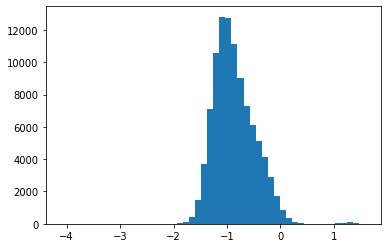

In [ ]:
plt.hist(aum_1[flip_index_1], bins=50)
plt.show()

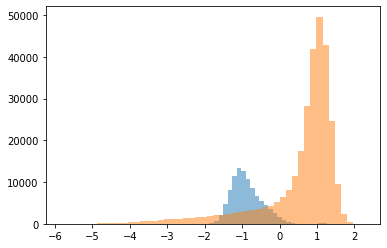

In [ ]:
plt.hist(aum_1[flip_index_1], alpha=0.5, bins=50)
plt.hist(aum_1[nf1], alpha=0.5, bins=50)
plt.show()

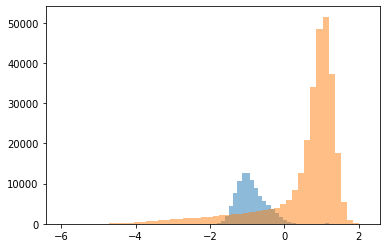

In [ ]:
plt.hist(aum_2[flip_index_2], alpha=0.5, bins=50)
plt.hist(aum_2[nf2], alpha=0.5, bins=50)
plt.show()

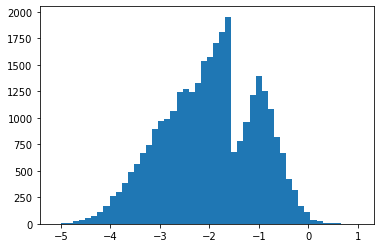

In [ ]:
plt.hist(aum_1[filtered_data], bins=50)
plt.show()

In [ ]:
sum(aum_1[filtered_data] > -1.18)

11283

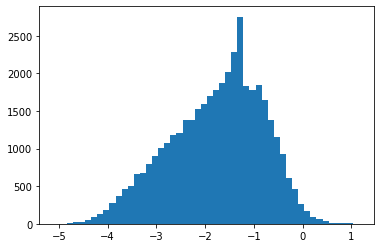

In [ ]:
plt.hist(aum_2[filtered_data], bins=50)
plt.show()

## Let see what examples have been filtered out

In [ ]:
start_index = 0
end_index = 40
for i in range(len(filtered_data)):
    if i < start_index:
        continue
    if i == end_index:
        break

    idx = int(filtered_data[i])
    
    print("This is example " + str(idx))
    print(train_set[idx]["premise"])
    print(train_set[idx]["hypothesis"])
    print(train_set[idx]["label"])
    print()

    



This is example 38
The word aswan actually means trade or market in ancient Egyptian, signifying its most pre-eminent activity.
Aswan's meaning has not changed over time.
2

This is example 50
Thus, with respect to the litigation services Congress has funded, there is no alternative channel for expression of the advocacy Congress seeks to restrict.
This is the only channel of expression of the advocacy that Congress seeks to restrict.
0

This is example 62
It might have seemed like manna from heaven - up to thousands of dollars dropping, often unexpectedly, into the hands of a half-million Kentucky and Indiana residents this month.
A recent law proposed by congress has resulted in the seizure of thousands of dollars from Kentucky residents.
2

This is example 71
Putting aside stage as a horse-drawn conveyance, a popular delicatessen, a part of a rocket, and an opportunity to mock Gail Sheehy (who seems to get a free ride from News Quiz participants), this question all but demanded the 

In [ ]:
human_filtered[85, 122?, 128, 140, 149, 291, 320]

In [ ]:
remain_data = list(set(range(len(train_set))) - set(filtered_data))
train_set = train_set[remain_data]